<h1 align="center">Advanced Image Processing and Analysis</h1>
<h3 align="center">ECE 4438B/ECE 9022/ECE 9202B/BIOMED 9519B/BIOPHYS 9519B/CAMI 9519B</h3>
<h4 align="center"><a href="mailto:echen29@uwo.ca"> Elvis Chen, PhD, LL</a></h4>
<h4 align="center">Robarts Research Institute, London</h4>
<h4 align="center">Department of Electrical and Computer Engineering, Western University</h4>
<h4 align="center">School of Biomedical Engineering, Western University</h4>
<h4 align="center">Department of Medical Biophysics, Western University</h4>
<h4 align="center">Day 06, January 22, 2019</h4>

### Introduction
In this notebook, we will explore using `matplotlib` to display images in our notebooks, and work towards developing a resuable function to display 2D, 3D, color, and label overlays for SimpleITK images.

We will also be looking at subtleties of working with image filters that requires the input images' to be overtlapping.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import SimpleITK as sitk
# Download data to work on
%run update_path_to_download_script
from downloaddata import fetch_data as fdata

In SimpleITK, the defult/bult-in function `Show` method actually saves the image to disk and lunches an external (user configurable) program (default to be ImageJ), to display the image.

In [2]:
img1 = sitk.ReadImage(fdata("cthead1.png"))
sitk.Show(img1, title="cthead1")

Fetching cthead1.png


Let us load an color image from the [Visible Human Project](https://en.wikipedia.org/wiki/Visible_Human_Project) dataset. I encourage you to read the wiki page and [this NIH link](https://www.nlm.nih.gov/research/visible/visible_human.html) to get an appreciation about the nature of this dataset.

A similar project with serially sectioned image is the [Visible Korean Human](http://vkh3.kisti.re.kr/) project.

In [3]:
img2 = sitk.ReadImage(fdata("VM1111Shrink-RGB.png"))
sitk.Show(img2, title="Visible Human Head")

Fetching VM1111Shrink-RGB.png


ImageJ is capable of handling gray-scale and multi-channel (e.g. RGB) images.

Alternatively, we can also use `matplotlib` to display the image. We have already seen the following commands. Instead of saving the image to a file, we can get a pointer to the image in the memory and display it directly:

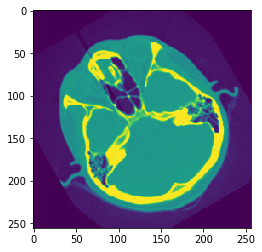

In [4]:
nda = sitk.GetArrayViewFromImage(img1)
plt.imshow(nda)

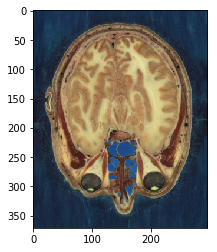

In [5]:
nda = sitk.GetArrayViewFromImage(img2)
ax = plt.imshow(nda)

Please pay attention to the size of the image as well as the color of the image. Notice the difference.

We can make our live a bit simplier by defining a function:

In [6]:
def myshow(img):
    nda = sitk.GetArrayViewFromImage(img)
    plt.imshow(nda)

Note we are using `sitk.GetArrayViewFromImage`. **Why**?

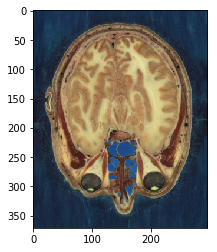

In [7]:
myshow(img2)

In [8]:
help(sitk.Expand)

Help on function Expand in module SimpleITK.SimpleITK:

Expand(*args, **kwargs)
    Expand(Image image1, VectorUInt32 expandFactors, itk::simple::InterpolatorEnum interpolator) -> Image
    
    
    
    Expand the size of an image by an integer factor in each dimension.
    
    
    This function directly calls the execute method of ExpandImageFilter in order to support a procedural API
    
    
    See:
     itk::simple::ExpandImageFilter for the object oriented interface



In [9]:
# The picture is too small! Can we enlarge by physically expand it?
print(img2.GetSize())
print(img2.GetDimension())

(297, 371)
2


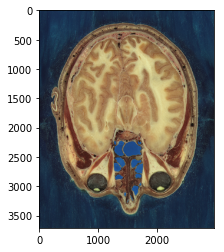

In [10]:
#img3 = sitk.Expand(img2, [10]*5)
#print(img3.GetSize())
#myshow(img3)
myshow(sitk.Expand(img2, [10]*5))

This image does not appear bigger.

There are many improvements that we can make:
* support 3D images
* include a title
* use physical pixel size for axis labels
* show image as gray values

In [11]:
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

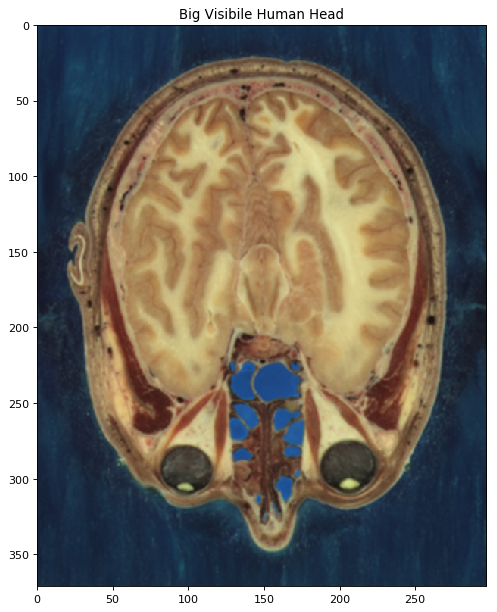

In [12]:
myshow(sitk.Expand(img2,[2,2]), title="Big Visibile Human Head")

## Tips and Tricks for Visualizing Segmentations
We start by loading a segmented image. As the segmentation is just an image with integral data, we can display the labels as we dould any other image:

Fetching 2th_cthead1.png


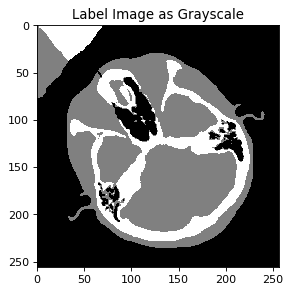

In [13]:
img1_seg = sitk.ReadImage(fdata("2th_cthead1.png"))
myshow(img1_seg, "Label Image as Grayscale")

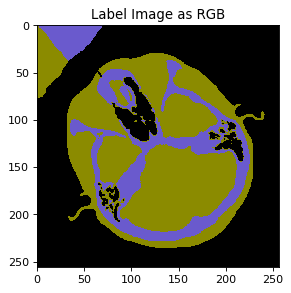

In [14]:
myshow(sitk.LabelToRGB(img1_seg), title="Label Image as RGB")

Most filters which take multiple images as arguments require that the images occupy the same physical space. That is the pixel you are operating must refer to the same location. Luckily for us our image and labels do occupy the same physical space, allowing us to overlay the segmentation onto the original image:

In [15]:
help(sitk.LabelOverlay)

Help on function LabelOverlay in module SimpleITK.SimpleITK:

LabelOverlay(*args, **kwargs)
    LabelOverlay(Image image, Image labelImage, double opacity=0.5, double backgroundValue=0.0, VectorUInt8 colormap) -> Image
    
    
    
    Apply a colormap to a label image and put it on top of the input
    image.
    
    
    This function directly calls the execute method of LabelOverlayImageFilter in order to support a procedural API
    
    
    See:
     itk::simple::LabelOverlayImageFilter for the object oriented interface



**From last week's class, remember we could not add 2 images (img1+img2) if the spacing are different?**

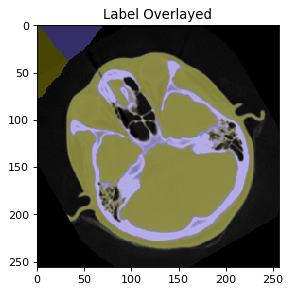

In [16]:
myshow(sitk.LabelOverlay(img1, img1_seg), title="Label Overlayed")

In [17]:
help(sitk.LabelContour)

Help on function LabelContour in module SimpleITK.SimpleITK:

LabelContour(image1, fullyConnected=False, backgroundValue=0)
    LabelContour(Image image1, bool fullyConnected=False, double backgroundValue=0) -> Image
    
    
    
    Labels the pixels on the border of the objects in a labeled image.
    
    
    This function directly calls the execute method of LabelContourImageFilter in order to support a procedural API
    
    
    See:
     itk::simple::LabelContourImageFilter for the object oriented interface



We can also overlay the label as contours:

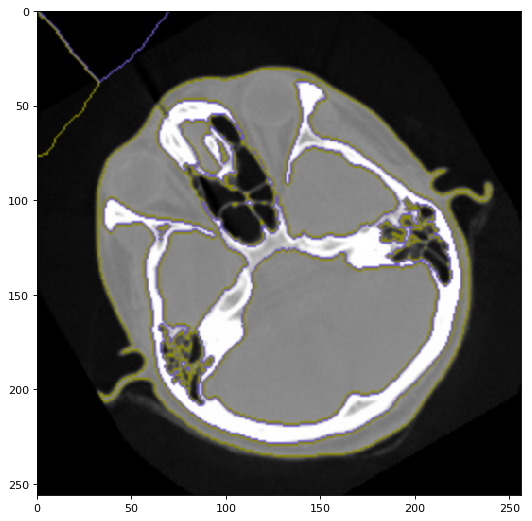

In [18]:
myshow(sitk.Expand(sitk.LabelOverlay(img1, sitk.LabelContour(img1_seg), 1.0), [2,2]))

What have we done here?  A demonstration of the image processing pipeline!

## Tips and Tricks for 3D image Visualization
Now lets move on to visualizing real MRI images with segmentations. The Surgical Planning Laboratory at Brigham and Women's Hospital has a wonderful [Multi-modality MRI-based Atlas of the Brain](http://www.spl.harvard.edu/publications/item/view/2037) that we can use.

Please note, what is done here is for convenience and is not the common way images are displayed for radiological work.

In [20]:
#img_T1 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd"))
#img_T2 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd"))
#img_labels = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/hncma-atlas.nrrd"))

# since NIH is currently down, we have to load it locally
img_T1 = sitk.ReadImage("..\\data\\volumes\\A1_grayT1.nrrd")
img_T2 = sitk.ReadImage("..\\data\\volumes\\A1_grayT2.nrrd")
img_labels = sitk.ReadImage("..\\data\\volumes\\hncma-atlas.nrrd")

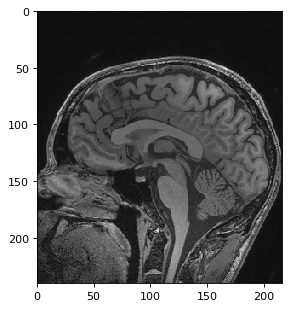

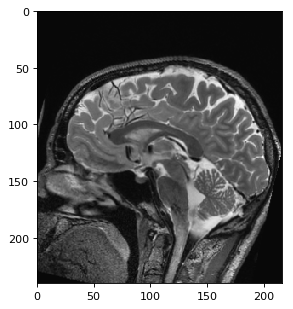

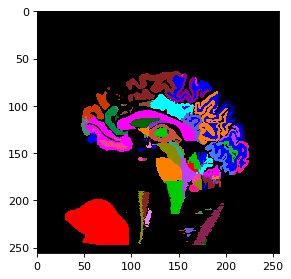

In [21]:
myshow(img_T1)
myshow(img_T2)
myshow(sitk.LabelToRGB(img_labels))

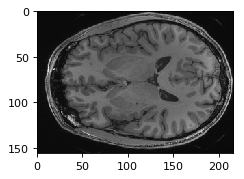

In [22]:
size = img_T1.GetSize()
myshow(img_T1[:,size[1]//2,:])

In [ ]:
slices =[img_T1[size[0]//2,:,:], img_T1[:,size[1]//2,:], img_T1[:,:,size[2]//2]]
myshow(sitk.Tile(slices, [3,1]), dpi=20)

In [ ]:
nslices = 5
slices = [ img_T1[:,:,s] for s in range(0, size[2], size[0]//(nslices+1))]
myshow(sitk.Tile(slices, [1,0]))

let us create a version of the show methods which allows the selection of slices to be displayed:

In [ ]:
def myshow3d(img, xslices=[], yslices=[], zslices=[], title=None, margin=0.05, dpi=80):
    size = img.GetSize()
    img_xslices = [img[s,:,:] for s in xslices]
    img_yslices = [img[:,s,:] for s in yslices]
    img_zslices = [img[:,:,s] for s in zslices]
    
    maxlen = max(len(img_xslices), len(img_yslices), len(img_zslices))
    
        
    img_null = sitk.Image([0,0], img.GetPixelID(), img.GetNumberOfComponentsPerPixel())
    
    img_slices = []
    d = 0
    
    if len(img_xslices):
        img_slices += img_xslices + [img_null]*(maxlen-len(img_xslices))
        d += 1
        
    if len(img_yslices):
        img_slices += img_yslices + [img_null]*(maxlen-len(img_yslices))
        d += 1
     
    if len(img_zslices):
        img_slices += img_zslices + [img_null]*(maxlen-len(img_zslices))
        d +=1
    
    if maxlen != 0:
        if img.GetNumberOfComponentsPerPixel() == 1:
            img = sitk.Tile(img_slices, [maxlen,d])
        #TO DO check in code to get Tile Filter working with vector images
        else:
            img_comps = []
            for i in range(0,img.GetNumberOfComponentsPerPixel()):
                img_slices_c = [sitk.VectorIndexSelectionCast(s, i) for s in img_slices]
                img_comps.append(sitk.Tile(img_slices_c, [maxlen,d]))
            img = sitk.Compose(img_comps)
            
    
    myshow(img, title, margin, dpi)

In [ ]:
myshow3d(img_T1,yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

In [ ]:
myshow3d(img_T2,yslices=range(50,size[1]-50,30), zslices=range(50,size[2]-50,20), dpi=30)

In [ ]:
myshow3d(sitk.LabelToRGB(img_labels),yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

We next visualize the T1 image with an overlay of the labels:

In [ ]:
# Why doesn't this work? The images do overlap in physical space.
myshow3d(sitk.LabelOverlay(img_T1,img_labels),yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

Two ways to solve our problem: (1) resample the labels onto the image grid (2) resample the image onto the label grid. The difference between the two from a computation standpoint depends on the grid sizes and on the interpolator used to estimate values at non-grid locations. 

Note interpolating a label image with an interpolator that can generate non-label values is problematic as you may end up with an image that has more classes/labels than your original. This is why we only use the nearest neighbor interpolator when working with label images.

In [ ]:
# Option 1: Resample the label image using the identity transformation
resampled_img_labels = sitk.Resample(img_labels, img_T1, sitk.Transform(), sitk.sitkNearestNeighbor,
                                     0.0, img_labels.GetPixelID())
# Overlay onto the T1 image, requires us to rescale the intensity of the T1 image to [0,255] and cast it so that it can 
# be combined with the color overlay (we use an alpha blending of 0.5).
myshow3d(sitk.LabelOverlay(sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8),resampled_img_labels, 0.5),
         yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

In [ ]:
# Option 2: Resample the T1 image using the identity transformation
resampled_T1 = sitk.Resample(img_T1, img_labels, sitk.Transform(), sitk.sitkLinear,
                             0.0, img_T1.GetPixelID())
# Overlay onto the T1 image, requires us to rescale the intensity of the T1 image to [0,255] and cast it so that it can 
# be combined with the color overlay (we use an alpha blending of 0.5).
myshow3d(sitk.LabelOverlay(sitk.Cast(sitk.RescaleIntensity(resampled_T1), sitk.sitkUInt8),img_labels, 0.5),
         yslices=range(50,size[1]-50,20), zslices=range(50,size[2]-50,20), dpi=30)

Why are the two displays above different? (hint: in the calls to the "myshow3d" function the indexes of the y and z slices are the same). 

### There and back again

In some cases you may want to work with the intensity values or labels outside of SimpleITK, for example you implement an algorithm in Python and you don't care about the physical spacing of things (you are actually assuming the volume is isotropic).

How do you get back to the physical space?

In [ ]:
def my_algorithm(image_as_numpy_array):
    # res is the image result of your algorithm, has the same grid size as the original image
    res = image_as_numpy_array
    return res

# There (run your algorithm), and back again (convert the result into a SimpleITK image)
res_image = sitk.GetImageFromArray(my_algorithm(sitk.GetArrayFromImage(img_T1)))

# Now lets add the original image to the processed one, why doesn't this work?
res_image + img_T1

When we converted the SimpleITK image to a numpy array we lost the spatial information (origin, spacing, direction cosine matrix). Converting the numpy array back to a SimpleITK image simply set the value of these components to reasonable defaults. We can easily restore the original values to deal with this issue.  

In [ ]:
res_image.CopyInformation(img_T1)
res_image + img_T1

The ``myshow`` and ``myshow3d`` functions are really useful. They have been copied into a "myshow.py" file so that they can be imported into other notebooks.